In [1]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
 
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

In [2]:
lemmatiser.lemmatize('jumped')

'jumped'

In [3]:
stemmer.stem('jumped')

'jump'

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
train = pd.read_csv('data/spooky/train.csv')
test = pd.read_csv('data/spooky/test.csv')
sample = pd.read_csv('data/spooky/sample_submission.csv')

In [7]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [9]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


# EDA

In [10]:
train.shape

(19579, 3)

In [11]:
train['text'].head()

0    This process, however, afforded me no means of...
1    It never once occurred to me that the fumbling...
2    In his left hand was a gold snuff box, from wh...
3    How lovely is spring As we looked from Windsor...
4    Finding nothing else, not even gold, the Super...
Name: text, dtype: object

In [12]:
from sklearn.utils import shuffle

In [13]:
train = shuffle(train)

# Vectorize with CountVectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
import nltk

In [16]:
lemm = nltk.WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [17]:
# Storing the entire training text in a list
text = list(train['text'].values)
# Calling our overwritten Count vectorizer
tf_cv_vec = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf_cv = tf_cv_vec.fit_transform(text)

In [18]:
tf_cv_df = pd.DataFrame(tf_cv.toarray(), columns=tf_cv_vec.get_feature_names())
tf_cv_df.head()

,aback,abandon,abandoned,abandoning,abandonment,abaout,abate,abatement,abbey,abbreviation,...,zest,zigzag,zigzagging,zimmer,zit,zodiacal,zokkar,zone,ædile,æronaut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Test/train split

In [19]:
from sklearn import model_selection

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(tf_cv_df, train['author'])

## Classify

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
nb = MultinomialNB()

In [23]:
scores = model_selection.cross_val_score(nb, X_train, y_train, cv=10)

In [24]:
np.mean(scores)

0.8190514448539099

In [25]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
nb.score(X_test, y_test)

0.8234933605720123

### Predict Class Probabilities for Test Data

In [27]:
# Storing the entire training text in a list
text = list(test['text'].values)
tf_cv = tf_cv_vec.transform(text)

In [28]:
tf_cv_df = pd.DataFrame(tf_cv.toarray(), columns=tf_cv_vec.get_feature_names())
tf_cv_df.head()

,aback,abandon,abandoned,abandoning,abandonment,abaout,abate,abatement,abbey,abbreviation,...,zest,zigzag,zigzagging,zimmer,zit,zodiacal,zokkar,zone,ædile,æronaut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
predicts = nb.predict_proba(tf_cv_df)

In [30]:
nb.classes_

array(['EAP', 'HPL', 'MWS'], dtype='<U3')

In [31]:
pred_proba_df = pd.DataFrame(predicts, index=test['id'], columns=nb.classes_)
pred_proba_df.head()

,EAP,HPL,MWS
id,,,
id02310,0.003606,0.000257,0.996137
id24541,0.999865,0.000130,0.000006
id00134,0.578733,0.421110,0.000157
id27757,0.049385,0.950613,0.000002
id04081,0.965464,0.027073,0.007462


In [32]:
auth_preds = pred_proba_df.idxmax(axis=1)
auth_preds.head()

id
id02310    MWS
id24541    EAP
id00134    EAP
id27757    HPL
id04081    EAP
dtype: object

# Vectorize with TFIDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
lemm = nltk.WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [35]:
# Storing the entire training text in a list
text = list(train['text'].values)
# Calling our overwritten Count vectorizer
tf_df_vec = TfidfVectorizer(max_df=0.95, 
                                min_df=2,
                                stop_words='english')
tf_df = tf_df_vec.fit_transform(text)

In [36]:
tf_df_df = pd.DataFrame(tf_df.toarray(), columns=tf_df_vec.get_feature_names())
tf_df_df.head()

,aback,abandon,abandoned,abandoning,abandonment,abaout,abate,abatement,abbey,abbreviation,...,zest,zigzag,zigzagging,zimmer,zit,zodiacal,zokkar,zone,ædile,æronaut
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Test/train split

In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(tf_df_df, train['author'])

## Classify

In [39]:
scores = model_selection.cross_val_score(nb, X_train, y_train, cv=10)

In [40]:
np.mean(scores)

0.8070704888082263

In [41]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
nb.score(X_test, y_test)

0.8214504596527068

# LDA Topic Modeling

In [43]:
eap = train[train['author'] == 'EAP']['text']
hpl = train[train['author'] == 'HPL']['text']
mws = train[train['author'] == 'MWS']['text']

In [44]:
# function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

## Determine optimal number of topics

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [57]:
Sum_of_squared_distances = []
sil_coefs = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tf_cv)
    Sum_of_squared_distances.append(km.inertia_)
    sil_coefs.append(silhouette_score(tf_cv, km.labels_))

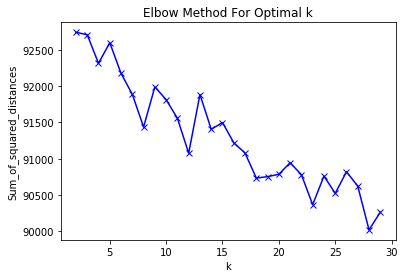

In [58]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

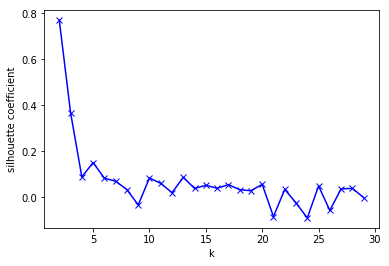

In [59]:
plt.plot(K, sil_coefs, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.show()

## Initiate model

In [45]:
from sklearn.decomposition import LatentDirichletAllocation

In [46]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

## Using CountVectorizer

In [47]:
lda.fit(tf_cv)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=11, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [43]:
n_top_words = 40
print("\nTopics in LDA model (using CountVectorizer): ")
tf_feature_names = tf_cv_vec.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model (using CountVectorizer): 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent w

## Using TFIDF

In [47]:
lda.fit(tf_df)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=11, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [48]:
n_top_words = 40
print("\nTopics in LDA model (using TFIDF): ")
tf_feature_names = tf_df_vec.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model (using TFIDF): 

Topic #0:agreed locked hotel captain la enemies dignity disappearance france et propose bird routine shutters sheehan trying accomplishment pillars securely sorrowful cohort justly calls recover hesitate traversed exhibiter defeat obeyed nodded community stamp preceded personally nice pratt cape steadied fruiterer clerk

Topic #1:write usually accomplished suggestion plainly powerful demand notwithstanding editor te oppodeldoc passages expedition dominion neat lollipop deity hurt communicated thomas vainly ugly kill arrangement necessity drama intend happier conquer lawless survive agreeable alas tangible harmless du induce fragment identical infirmity

Topic #2:profound safe von joe steady daown aout visits gang em ate est cutting gawd guests couch portrait burn gradual newspapers bushes struggling draught merciful beg background ether precipitated hatheg ascertain sweep development arrives glassy deposes empire started consumed scarlet entertain


In [44]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [45]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

# NMF Topic Modeling

In [49]:
from sklearn.decomposition import NMF

In [50]:
nmf = NMF(n_components=11, max_iter=5,
                                random_state = 0)

## Using CountVectorizer

In [51]:
nmf.fit(tf_cv)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=5,
  n_components=11, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [52]:
n_top_words = 40
print("\nTopics in NMF model: ")
tf_feature_names = tf_cv_vec.get_feature_names()
print_top_words(nmf, tf_feature_names, n_top_words)


Topics in NMF model: 

Topic #0:great word earth mind saw world thought felt deep love sea heard beauty evil spirit feeling scene shall light away good lovely god came multitude far form wisdom appeared wind oh nature voice near diotima moon human men lip say

Topic #1:time long hour come year thousand space short thought friend place matter way say make moment period new soon mean fear shall certain body foot room lost point length far line having second spent manner course memory idea grief person

Topic #2:man old god young farewell mr nature seen woman face power dark work good terrible human small animal tell city believe bearded way say sir person business water air sound long wonder set blind form general came high book dr

Topic #3:day night hour came passed long dream new far away sleep thousand month sun morning men mr late room having city went father work period week hill body house told year dark following home let raymond grew early place thought

Topic #4:thing say men 

## Using TFIDF

In [53]:
nmf.fit(tf_df)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=5,
  n_components=11, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [54]:
n_top_words = 40
print("\nTopics in NMF model: ")
tf_feature_names = tf_df_vec.get_feature_names()
print_top_words(nmf, tf_feature_names, n_top_words)


Topics in NMF model: 

Topic #0:life like eyes death heart great mind thought left years world felt things earth long far little men love father hand words place human friend good nature soon head moment house having length away strange voice raymond old gave half

Topic #1:said dupin little let sir yes dear heard better quite mean friend thousand proceed sure come present pounds matter father words raymond adrian somebody enjoy prefect tone big paper legrand talk great smith coming second fool reply comprehend pardon turning

Topic #2:did come like appear perdita understand return expected believe fail fear look expect feel knew write despair dark proceed pass best sleep change looked mean dare tell pay wish prove forgotten companion reason grew asked occur west saying dogs thief

Topic #3:man old great young god seen dead animal lived absent woman face bearded sat business terrible good sir respect blind small feared fool spoke reason loved room creation follow poet years genius ord

In [193]:
first_topic = nmf_model.components_[0]
second_topic = nmf_model.components_[1]
third_topic = nmf_model.components_[2]
fourth_topic = nmf_model.components_[3]

In [194]:
first_topic_words_nmf = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words_nmf = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words_nmf = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words_nmf = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

# Analysis

- select best topics
- match back to author